In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from labelbox import Client, OntologyBuilder
import labelbox
import pandas as pd
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms
import segmentation_models_pytorch as smp
import albumentations as albu 
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.utils import class_weight
from torch.utils.data import random_split
from segmentation_models_pytorch import utils
import csv
import json

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
 # helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
train_kop_dir = '/home/sonawane/backup/2_Keine_offenen_Poren/'
mask_kop_dir = '/home/sonawane/backup/kop_labels_colour/'
kop_file_path = '/home/sonawane/backup/export-kof.csv'

# Read the CSV file into a pandas DataFra//me
df = pd.read_csv(kop_file_path)
#Generating training ids
kop_id = df['data_row.external_id'] 
kop_id_list = kop_id.tolist()
#print(kop_id_list)

##########################################################

train_op_dir = '/home/sonawane/backup/kikosa_data/1_Offene-Poren/'
mask_op_dir = '/home/sonawane/backup/op_labels_colour/'
op_file_path = '/home/sonawane/backup/Offene-Porem.csv'

dt= pd.read_csv(op_file_path)
op_id = dt['data_row/external_id'] 
op_id_list = op_id.tolist()
op_ids = []
for filename in op_id_list:
    if filename.endswith('.jpg') and '.' in filename:
        op_ids.append(filename.rsplit('.', 1)[0])
print(op_ids)

##########################################################

train_gop_dir = '/home/sonawane/backup/3_Grenzfall_offene_Pore/'
mask_gop_dir = '/home/sonawane/backup/grenzfall_op_labels_colour/'
csv_file_path = '/home/sonawane/backup/Grenzfall_op.csv'

list= pd.read_csv(csv_file_path)
grenzfall_op_id = list['data_row.external_id'] 
gop_id_list = grenzfall_op_id.tolist()
gop_ids = []
for filename in gop_id_list:
    if filename.endswith('.jpg') and '.' in filename:
        gop_ids.append(filename.rsplit('.', 1)[0])
print(len(gop_ids))

##########################################################

import ndjson
import re

train_gkop_dir = '/home/sonawane/backup/4_Grenzfall_keine_offene_Pore/'
mask_gkop_dir = '/home/sonawane/backup/grenzfall_keine_labels_colour/'
# Define the path to your JSON file
json_file_path = '/home/sonawane/backup//Export v2 project - Grenzfall_keine - 3_12_2024.ndjson'
with open(json_file_path, 'r') as f:
    data = ndjson.load(f)
image_list = []
for i, d in enumerate(data):
    name = data[i]['data_row']['external_id']
    image_list.append(name)
# Process the IDs further as needed
gkop_id = []
for filename in image_list:
    if isinstance(filename, str) and re.search(r'( - Copy)?\.jpg$', filename):
        gkop_id.append(re.sub(r'( - Copy)?\.jpg$', '', filename))
print(gkop_id)


['0°-Ansicht_Probe_1422', '0°-Ansicht_Probe_1423', '0°-Ansicht_Probe_1676', '0°-Ansicht_Probe_1677', '0°-Ansicht_Probe_1678', '0°-Ansicht_Probe_1679', '0°-Ansicht_Probe_1680', '0°-Ansicht_Probe_1682', '0°-Ansicht_Probe_1683', '0°-Ansicht_Probe_1685', '0°-Ansicht_Probe_1688', '0°-Ansicht_Probe_1689', '0°-Ansicht_Probe_1696']
11
['0°-Ansicht_Probe_1163', '0°-Ansicht_Probe_1167', '0°-Ansicht_Probe_1181', '0°-Ansicht_Probe_1202', '0°-Ansicht_Probe_1228', '0°-Ansicht_Probe_1254', '0°-Ansicht_Probe_1255', '0°-Ansicht_Probe_1324', '0°-Ansicht_Probe_1338', '0°-Ansicht_Probe_1338', '0°-Ansicht_Probe_1343', '0°-Ansicht_Probe_1345', '0°-Ansicht_Probe_1439', '0°-Ansicht_Probe_1442', '0°-Ansicht_Probe_1443', '0°-Ansicht_Probe_1443', '0°-Ansicht_Probe_1445', '0°-Ansicht_Probe_1446', '0°-Ansicht_Probe_1514']


In [4]:
class SegmentationDataset(BaseDataset):
    CLASSES = ['Background', 'Pores', 'Open Pores', 'Weld']
    PIXEL_TO_LABEL = {60: 'Background', 78: 'Open Pores', 185: 'Pores', 216: 'Weld'}

    def __init__(self, images_dir, id_list, output_dir=None, augmentation=None, classes=None, preprocessing=None):
        self.output_dir = output_dir
        self.id_list = id_list
        self.images_dir = images_dir
        self.classes = [self.CLASSES.index(cls) for cls in classes]
        self.class_values = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, index):
        img_id = self.id_list[index]
        img_path = os.path.join(self.images_dir, f"{img_id}.tif")
        
        image = self.read_image(img_path)
        mask = self.read_mask(img_id)

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.id_list)

    def read_image(self, img_path):
        image_pil = Image.open(img_path).convert("RGB")
        image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

    def read_mask(self, img_id):
        mask_path_copy = os.path.join(self.output_dir, f"{img_id} - Copy.png")
        mask_path_normal = os.path.join(self.output_dir, f"{img_id}.png")
        
        if os.path.exists(mask_path_copy):
            mask_path = mask_path_copy
        elif os.path.exists(mask_path_normal):
            mask_path = mask_path_normal
        else:
            raise FileNotFoundError(f"Mask file not found for ID {img_id}")

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_labels = np.vectorize(self.PIXEL_TO_LABEL.get)(mask)
        masks = [(mask_labels == cls) for cls in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        return mask / np.max(mask)

dataset = SegmentationDataset(train_gop_dir, gop_ids, mask_gop_dir, classes=[ 'Pores', 'Open Pores', 'Weld' ])
images, masks = dataset[2]  # Access the first sample
print(images.shape)
print(np.unique(masks))
print(masks.shape)

(900, 1600, 3)
[0. 1.]
(900, 1600, 3)


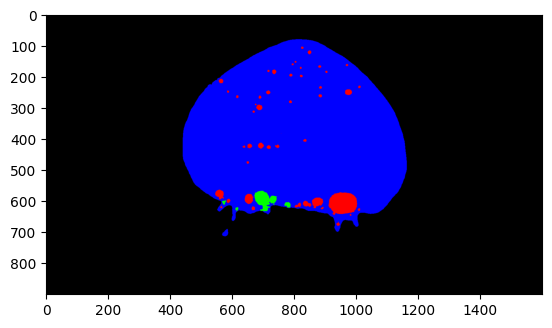

In [5]:
def visualize_channels(mask):
    composite_image = mask[:, :, :3]  # Take the first three channels as RGB
    composite_image *= 255  # Scale values to the 0-255 range

    # Display the composite image
    plt.imshow(composite_image.astype('uint8'))
    plt.show()

# Assuming 'masks' is your 4-channel mask
visualize_channels(masks)


In [6]:

##########################################################
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Resize(height=512, width=512, always_apply=True),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(test_transform)

In [7]:
def create_segmentation_model(encoder='vgg11', encoder_weights='imagenet', 
                              classes=['Pores', 'Open Pores', 'Weld'], 
                              activation='sigmoid', in_channels=3):
   
    # Check if CUDA is available
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Check if the specified encoder is valid
    valid_encoders = smp.encoders.get_encoder_names()
    if encoder not in valid_encoders:
        raise ValueError(f"Invalid encoder '{encoder}'. Available encoders: {valid_encoders}")

    # Check if the specified activation function is valid
    valid_activations = ['sigmoid', 'softmax2d', None]
    if activation not in valid_activations:
        raise ValueError(f"Invalid activation '{activation}'. Choose from: {valid_activations}")

    # Create the segmentation model
    model = smp.Unet(
        encoder_name=encoder,
        encoder_weights=encoder_weights,
        classes=len(classes),
        activation=activation,
        in_channels=in_channels
    )
    
    # Move the model to the appropriate device (GPU or CPU)
    model = model.to(device)

    return model

# Example usage:
model = create_segmentation_model()


In [8]:
ENCODER='vgg11'
ENCODER_WEIGHTS='imagenet'
CLASSES=['Pores', 'Open Pores', 'Weld']
# Define the preprocessing function based on your encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Create the dataset without augmentation
train_kop_dataset = SegmentationDataset(
    images_dir=train_kop_dir,
    id_list=kop_id_list,
    output_dir=mask_kop_dir,
    augmentation= None,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_op_dataset = SegmentationDataset(
    images_dir=train_op_dir,
    id_list=op_ids,
    output_dir=mask_op_dir,
    augmentation= None,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_gop_dataset = SegmentationDataset(
    images_dir = train_gop_dir,
    id_list = gop_ids,
    output_dir= mask_gop_dir,
    augmentation=None,
    classes= CLASSES,
    preprocessing= get_preprocessing(preprocessing_fn)
)
train_grezfall_keine_dataset = SegmentationDataset(
    images_dir= train_gkop_dir,
    id_list = gkop_id,
    output_dir = mask_gkop_dir,
    augmentation= None,
    classes= CLASSES,
    preprocessing= get_preprocessing(preprocessing_fn) 
)

train_dataset = ConcatDataset([train_kop_dataset, train_op_dataset, train_gop_dataset, train_grezfall_keine_dataset])
total_train_samples = len(train_dataset)

validation_split = 0.2
val_size = int(validation_split * total_train_samples)
train_size = total_train_samples - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=12)

print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")

Number of samples in training set: 44
Number of samples in validation set: 11


In [9]:
for images, masks in train_loader:
    print("Image shape:", images.shape)  # Shape of the images tensor
    print("Mask shape:", masks.shape)    # Shape of the masks tensor
    break  # Break the loop after printing the shape of the first batch


Image shape: torch.Size([6, 3, 512, 512])
Mask shape: torch.Size([6, 3, 512, 512])


In [24]:
class CustomDiceLoss(smp.utils.losses.DiceLoss):
    def __init__(self, ignore_index=-1, *args, **kwargs):
        super(CustomDiceLoss, self).__init__(*args, **kwargs)
        self.ce_loss = torch.nn.CrossEntropyLoss(ignore_index=ignore_index)

    def forward(self, y_pred, y_true):
        dice_loss = super(CustomDiceLoss, self).forward(y_pred, y_true)
        ce_loss = self.ce_loss(y_pred, y_true.argmax(1))
        return dice_loss


In [11]:
class SegmentationTrainer:
    def __init__(self, encoder_name, model, optimizer, loss_fn, num_epochs, classes, train_loader, val_loader,csv_filename, device):
        self.encoder_name = encoder_name
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.num_epochs = num_epochs
        self.classes = classes
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.csv_filename = csv_filename
        self.device = device
    
    def preprocess_data(self, image, mask):
        return image.to(device=self.device), mask.float().to(device=self.device)

    def calculate_per_class_scores(self, predictions, mask, threshold=0.5):
        class_iou_scores = []
        class_dice_scores = []
        for class_idx in range(mask.size(1)):
            class_mask = mask[:, class_idx, :, :]
            if torch.sum(class_mask) > 0:
                class_predictions = predictions[:, class_idx]

                class_predictions_int = class_predictions.round().long()
                class_mask_int = class_mask.round().long()

                tp, fp, fn, tn = smp.metrics.get_stats(class_predictions_int, class_mask_int, mode='multilabel', threshold=threshold)
                class_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro')
                class_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
                class_iou_scores.append(class_iou_score)
                class_dice_scores.append(1 - class_f1_score)
            else:
                class_iou_scores.append(0)
                class_dice_scores.append(0)
        return class_iou_scores, class_dice_scores

    def calculate_overall_scores(self, predictions, mask, threshold=0.5):
        mask_int = mask.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(predictions.round(), mask_int, mode='multilabel', threshold=threshold)
        overall_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        overall_dice_loss = 1 - smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        return overall_iou_score, overall_dice_loss
    
    def train_one_epoch(self):
        # Training loop
        train_loop = tqdm(self.train_loader)
        train_class_iou_scores = []
        train_class_dice_scores = []
        train_overall_iou_scores = []
        train_overall_dice_losses = []

        for image, mask in train_loop:
            image, mask = self.preprocess_data(image, mask)
                
            # Forward pass
            predictions = self.model(image)
            loss = self.loss_fn(predictions, mask)
                
            # Calculate per-class IoU and Dice scores
            class_iou, class_dice = self.calculate_per_class_scores(predictions, mask)
            train_class_iou_scores.extend(class_iou)
            train_class_dice_scores.extend(class_dice)
                
            # Calculate overall IoU and Dice scores
            overall_iou, overall_dice = self.calculate_overall_scores(predictions, mask)
            train_overall_iou_scores.append(overall_iou)
            train_overall_dice_losses.append(overall_dice)

            # Backward pass
            self.model.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update tqdm loop
            train_loop.set_postfix(loss=loss.item())

        # Validation loop
        val_loop = tqdm(val_loader)
        val_class_iou_scores = []
        val_class_dice_scores = []
        val_overall_iou_scores = []
        val_overall_dice_losses = []

        for image, mask in val_loop:
            image, mask = self.preprocess_data(image, mask)
                
            # Forward pass
            predictions = self.model(image)
            loss = self.loss_fn(predictions, mask)
                
            # Calculate per-class IoU and Dice scores
            class_iou, class_dice = self.calculate_per_class_scores(predictions, mask)
            val_class_iou_scores.extend(class_iou)
            val_class_dice_scores.extend(class_dice)
                
            # Calculate overall IoU and Dice scores
            overall_iou, overall_dice = self.calculate_overall_scores(predictions, mask)
            val_overall_iou_scores.append(overall_iou)
            val_overall_dice_losses.append(overall_dice)

            # Update tqdm loop
            val_loop.set_postfix(loss=loss.item())

        return train_class_iou_scores, train_class_dice_scores, train_overall_dice_losses, val_overall_dice_losses, val_class_iou_scores, val_class_dice_scores
    
   

In [77]:
csv_filename = "segmentation_result.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoders = ['vgg11', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
encoder_weights = 'imagenet'
CLASSES = ['Pores', 'Open Pores', 'Weld']
num_classes = len(CLASSES)
best_model_dir = '/home/sonawane/backup/'

# Open the CSV file for writing
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Encoder', 'Epoch', 'Train Class Score', 'Val Class Score', 'Avg Train Dice Loss', 'Avg Val Dice Loss'])

    best_val_iou = {encoder: float('inf') for encoder in encoders}  # Dictionary to store best validation IoU for each encoder
    best_model_paths = {}  # Dictionary to store paths of best models for each encoder

    for encoder in encoders:
        model = smp.Unet(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            classes=num_classes,
            activation='sigmoid',
            in_channels=3
        ).to(DEVICE)
        num_epochs = 75

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = smp.utils.losses.DiceLoss()
        trainer = SegmentationTrainer(encoder, model, optimizer, loss_fn, num_epochs, CLASSES, train_loader, val_loader, csv_filename, DEVICE)
        
        for epoch in range(num_epochs):
            print(f"Current encoder: {encoder}, Epoch: {epoch}")
            best_model_path = os.path.join(best_model_dir, f"best_model_{encoder}.pt")

            train_class_iou_scores, train_class_dice_scores, train_overall_dice_losses, val_overall_dice_losses, val_class_iou_scores, val_class_dice_score = trainer.train_one_epoch()

            avg_train_dice_loss = np.mean([loss.item() for loss in train_overall_dice_losses])
            avg_val_dice_loss = np.mean([loss.item() for loss in val_overall_dice_losses])

            current_val_dice_loss = np.mean([loss.item() for loss in val_overall_dice_losses])
            if current_val_dice_loss < best_val_iou[encoder]:
                best_val_iou[encoder] = current_val_dice_loss
                best_model_paths[encoder] = best_model_path
                torch.save(model.state_dict(), best_model_path)

            train_class_scores_dict = {class_name: {'IoU Score': iou_score.mean().item(), 'Dice Score': dice_score.mean().item()} 
                                for class_name, iou_score, dice_score in zip(CLASSES, train_class_iou_scores, train_class_dice_scores)}

            val_class_scores_dict = {class_name: {'IoU Score': iou_score.mean().item(), 'Dice Score': dice_score.mean().item()} 
                                for class_name, iou_score, dice_score in zip(CLASSES, val_class_iou_scores, val_class_dice_score)}
            train_class_scores_json = json.dumps(train_class_scores_dict)
            val_class_scores_json = json



Current encoder: vgg11, Epoch: 0


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.629]


Current encoder: vgg11, Epoch: 1


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.541]


Current encoder: vgg11, Epoch: 2


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.44] 


Current encoder: vgg11, Epoch: 3


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.338]


Current encoder: vgg11, Epoch: 4


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.259]


Current encoder: vgg11, Epoch: 5


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.165]


Current encoder: vgg11, Epoch: 6


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.119]


Current encoder: vgg11, Epoch: 7


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0847]


Current encoder: vgg11, Epoch: 8


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0668]


Current encoder: vgg11, Epoch: 9


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0575]


Current encoder: vgg11, Epoch: 10


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0666]


Current encoder: vgg11, Epoch: 11


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0552]


Current encoder: vgg11, Epoch: 12


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0577]


Current encoder: vgg11, Epoch: 13


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0512]


Current encoder: vgg11, Epoch: 14


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0398]


Current encoder: vgg11, Epoch: 15


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.046] 


Current encoder: vgg11, Epoch: 16


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0363]


Current encoder: vgg11, Epoch: 17


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.0305]


Current encoder: vgg11, Epoch: 18


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.03]  


Current encoder: vgg11, Epoch: 19


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0315]


Current encoder: vgg11, Epoch: 20


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0244]


Current encoder: vgg11, Epoch: 21


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0251]


Current encoder: vgg11, Epoch: 22


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0384]


Current encoder: vgg11, Epoch: 23


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0318]


Current encoder: vgg11, Epoch: 24


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0209]


Current encoder: vgg11, Epoch: 25


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0278]


Current encoder: vgg11, Epoch: 26


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0199]


Current encoder: vgg11, Epoch: 27


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.028] 


Current encoder: vgg11, Epoch: 28


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0201]


Current encoder: vgg11, Epoch: 29


100%|██████████| 2/2 [00:03<00:00,  1.71s/it, loss=0.0246]


Current encoder: vgg11, Epoch: 30


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0283]


Current encoder: vgg11, Epoch: 31


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0292]


Current encoder: vgg11, Epoch: 32


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0212]


Current encoder: vgg11, Epoch: 33


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0246]


Current encoder: vgg11, Epoch: 34


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0207]


Current encoder: vgg11, Epoch: 35


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0274]


Current encoder: vgg11, Epoch: 36


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0193]


Current encoder: vgg11, Epoch: 37


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0179]


Current encoder: vgg11, Epoch: 38


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0246]


Current encoder: vgg11, Epoch: 39


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.021] 


Current encoder: vgg11, Epoch: 40


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0313]


Current encoder: vgg11, Epoch: 41


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0301]


Current encoder: vgg11, Epoch: 42


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0215]


Current encoder: vgg11, Epoch: 43


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.021]


Current encoder: vgg11, Epoch: 44


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0215]


Current encoder: vgg11, Epoch: 45


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0183]


Current encoder: vgg11, Epoch: 46


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0294]


Current encoder: vgg11, Epoch: 47


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0226]


Current encoder: vgg11, Epoch: 48


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0282]


Current encoder: vgg11, Epoch: 49


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0205]


Current encoder: vgg11, Epoch: 50


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0333]


Current encoder: vgg11, Epoch: 51


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0156]


Current encoder: vgg11, Epoch: 52


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0404]


Current encoder: vgg11, Epoch: 53


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0182]


Current encoder: vgg11, Epoch: 54


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0159]


Current encoder: vgg11, Epoch: 55


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0182]


Current encoder: vgg11, Epoch: 56


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0183]


Current encoder: vgg11, Epoch: 57


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0161]


Current encoder: vgg11, Epoch: 58


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.025] 


Current encoder: vgg11, Epoch: 59


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0265]


Current encoder: vgg11, Epoch: 60


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0123]


Current encoder: vgg11, Epoch: 61


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0169]


Current encoder: vgg11, Epoch: 62


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0178]


Current encoder: vgg11, Epoch: 63


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0205]


Current encoder: vgg11, Epoch: 64


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0157]


Current encoder: vgg11, Epoch: 65


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0192]


Current encoder: vgg11, Epoch: 66


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0204]


Current encoder: vgg11, Epoch: 67


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0209]


Current encoder: vgg11, Epoch: 68


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0175]


Current encoder: vgg11, Epoch: 69


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.0165]


Current encoder: vgg11, Epoch: 70


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0191]


Current encoder: vgg11, Epoch: 71


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0203]


Current encoder: vgg11, Epoch: 72


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0205]


Current encoder: vgg11, Epoch: 73


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.021] 


Current encoder: vgg11, Epoch: 74


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0183]


Current encoder: resnet18, Epoch: 0


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.662]


Current encoder: resnet18, Epoch: 1


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.589]


Current encoder: resnet18, Epoch: 2


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.502]


Current encoder: resnet18, Epoch: 3


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.404]


Current encoder: resnet18, Epoch: 4


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.304]


Current encoder: resnet18, Epoch: 5


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.217]


Current encoder: resnet18, Epoch: 6


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.158]


Current encoder: resnet18, Epoch: 7


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.111]


Current encoder: resnet18, Epoch: 8


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.098]


Current encoder: resnet18, Epoch: 9


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.109] 


Current encoder: resnet18, Epoch: 10


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.105] 


Current encoder: resnet18, Epoch: 11


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0753]


Current encoder: resnet18, Epoch: 12


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0743]


Current encoder: resnet18, Epoch: 13


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0663]


Current encoder: resnet18, Epoch: 14


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0913]


Current encoder: resnet18, Epoch: 15


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0502]


Current encoder: resnet18, Epoch: 16


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0519]


Current encoder: resnet18, Epoch: 17


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0345]


Current encoder: resnet18, Epoch: 18


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0443]


Current encoder: resnet18, Epoch: 19


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0386]


Current encoder: resnet18, Epoch: 20


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.029] 


Current encoder: resnet18, Epoch: 21


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0285]


Current encoder: resnet18, Epoch: 22


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0411]


Current encoder: resnet18, Epoch: 23


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0418]


Current encoder: resnet18, Epoch: 24


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0341]


Current encoder: resnet18, Epoch: 25


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0307]


Current encoder: resnet18, Epoch: 26


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0392]


Current encoder: resnet18, Epoch: 27


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0299]


Current encoder: resnet18, Epoch: 28


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0265]


Current encoder: resnet18, Epoch: 29


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0285]


Current encoder: resnet18, Epoch: 30


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0277]


Current encoder: resnet18, Epoch: 31


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0248]


Current encoder: resnet18, Epoch: 32


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0273]


Current encoder: resnet18, Epoch: 33


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0268]


Current encoder: resnet18, Epoch: 34


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0247]


Current encoder: resnet18, Epoch: 35


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.023] 


Current encoder: resnet18, Epoch: 36


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0236]


Current encoder: resnet18, Epoch: 37


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0317]


Current encoder: resnet18, Epoch: 38


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0327]


Current encoder: resnet18, Epoch: 39


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0275]


Current encoder: resnet18, Epoch: 40


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0254]


Current encoder: resnet18, Epoch: 41


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0244]


Current encoder: resnet18, Epoch: 42


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0336]


Current encoder: resnet18, Epoch: 43


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0309]


Current encoder: resnet18, Epoch: 44


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0307]


Current encoder: resnet18, Epoch: 45


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0368]


Current encoder: resnet18, Epoch: 46


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0263]


Current encoder: resnet18, Epoch: 47


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.025] 


Current encoder: resnet18, Epoch: 48


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0253]


Current encoder: resnet18, Epoch: 49


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0237]


Current encoder: resnet18, Epoch: 50


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0229]


Current encoder: resnet18, Epoch: 51


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0227]


Current encoder: resnet18, Epoch: 52


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.024] 


Current encoder: resnet18, Epoch: 53


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0227]


Current encoder: resnet18, Epoch: 54


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0231]


Current encoder: resnet18, Epoch: 55


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0231]


Current encoder: resnet18, Epoch: 56


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0228]


Current encoder: resnet18, Epoch: 57


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0224]


Current encoder: resnet18, Epoch: 58


100%|██████████| 2/2 [00:03<00:00,  1.71s/it, loss=0.0241]


Current encoder: resnet18, Epoch: 59


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0242]


Current encoder: resnet18, Epoch: 60


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0237]


Current encoder: resnet18, Epoch: 61


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0222]


Current encoder: resnet18, Epoch: 62


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0215]


Current encoder: resnet18, Epoch: 63


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0239]


Current encoder: resnet18, Epoch: 64


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0236]


Current encoder: resnet18, Epoch: 65


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0227]


Current encoder: resnet18, Epoch: 66


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0225]


Current encoder: resnet18, Epoch: 67


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0234]


Current encoder: resnet18, Epoch: 68


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0257]


Current encoder: resnet18, Epoch: 69


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0245]


Current encoder: resnet18, Epoch: 70


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0239]


Current encoder: resnet18, Epoch: 71


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0238]


Current encoder: resnet18, Epoch: 72


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0256]


Current encoder: resnet18, Epoch: 73


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0273]


Current encoder: resnet18, Epoch: 74


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.024]


Current encoder: resnet34, Epoch: 0


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.706]


Current encoder: resnet34, Epoch: 1


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.614]


Current encoder: resnet34, Epoch: 2


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.507]


Current encoder: resnet34, Epoch: 3


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.38] 


Current encoder: resnet34, Epoch: 4


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.248]


Current encoder: resnet34, Epoch: 5


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.167]


Current encoder: resnet34, Epoch: 6


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.104]


Current encoder: resnet34, Epoch: 7


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0762]


Current encoder: resnet34, Epoch: 8


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0771]


Current encoder: resnet34, Epoch: 9


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0525]


Current encoder: resnet34, Epoch: 10


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0452]


Current encoder: resnet34, Epoch: 11


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0404]


Current encoder: resnet34, Epoch: 12


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0369]


Current encoder: resnet34, Epoch: 13


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0311]


Current encoder: resnet34, Epoch: 14


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0335]


Current encoder: resnet34, Epoch: 15


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0311]


Current encoder: resnet34, Epoch: 16


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0275]


Current encoder: resnet34, Epoch: 17


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0261]


Current encoder: resnet34, Epoch: 18


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0253]


Current encoder: resnet34, Epoch: 19


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.027]


Current encoder: resnet34, Epoch: 20


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0277]


Current encoder: resnet34, Epoch: 21


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0283]


Current encoder: resnet34, Epoch: 22


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0199]


Current encoder: resnet34, Epoch: 23


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0193]


Current encoder: resnet34, Epoch: 24


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.028]


Current encoder: resnet34, Epoch: 25


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0253]


Current encoder: resnet34, Epoch: 26


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.025] 


Current encoder: resnet34, Epoch: 27


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0283]


Current encoder: resnet34, Epoch: 28


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0299]


Current encoder: resnet34, Epoch: 29


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.026] 


Current encoder: resnet34, Epoch: 30


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0261]


Current encoder: resnet34, Epoch: 31


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0257]


Current encoder: resnet34, Epoch: 32


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0257]


Current encoder: resnet34, Epoch: 33


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0289]


Current encoder: resnet34, Epoch: 34


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0258]


Current encoder: resnet34, Epoch: 35


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0188]


Current encoder: resnet34, Epoch: 36


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0168]


Current encoder: resnet34, Epoch: 37


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0202]


Current encoder: resnet34, Epoch: 38


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.023] 


Current encoder: resnet34, Epoch: 39


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0188]


Current encoder: resnet34, Epoch: 40


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0196]


Current encoder: resnet34, Epoch: 41


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0241]


Current encoder: resnet34, Epoch: 42


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0186]


Current encoder: resnet34, Epoch: 43


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0215]


Current encoder: resnet34, Epoch: 44


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0179]


Current encoder: resnet34, Epoch: 45


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.025] 


Current encoder: resnet34, Epoch: 46


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0233]


Current encoder: resnet34, Epoch: 47


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0151]


Current encoder: resnet34, Epoch: 48


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0217]


Current encoder: resnet34, Epoch: 49


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0179]


Current encoder: resnet34, Epoch: 50


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0169]


Current encoder: resnet34, Epoch: 51


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0158]


Current encoder: resnet34, Epoch: 52


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0192]


Current encoder: resnet34, Epoch: 53


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0183]


Current encoder: resnet34, Epoch: 54


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0146]


Current encoder: resnet34, Epoch: 55


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0153]


Current encoder: resnet34, Epoch: 56


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0167]


Current encoder: resnet34, Epoch: 57


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.019] 


Current encoder: resnet34, Epoch: 58


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0188]


Current encoder: resnet34, Epoch: 59


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.014] 


Current encoder: resnet34, Epoch: 60


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0185]


Current encoder: resnet34, Epoch: 61


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0211]


Current encoder: resnet34, Epoch: 62


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0196]


Current encoder: resnet34, Epoch: 63


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0183]


Current encoder: resnet34, Epoch: 64


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.024] 


Current encoder: resnet34, Epoch: 65


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0173]


Current encoder: resnet34, Epoch: 66


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0179]


Current encoder: resnet34, Epoch: 67


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0167]


Current encoder: resnet34, Epoch: 68


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0179]


Current encoder: resnet34, Epoch: 69


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0204]


Current encoder: resnet34, Epoch: 70


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0215]


Current encoder: resnet34, Epoch: 71


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.026] 


Current encoder: resnet34, Epoch: 72


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0236]


Current encoder: resnet34, Epoch: 73


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0187]


Current encoder: resnet34, Epoch: 74


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0216]


Current encoder: resnet50, Epoch: 0


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.654]


Current encoder: resnet50, Epoch: 1


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.57] 


Current encoder: resnet50, Epoch: 2


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.476]


Current encoder: resnet50, Epoch: 3


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.369]


Current encoder: resnet50, Epoch: 4


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.266]


Current encoder: resnet50, Epoch: 5


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.167]


Current encoder: resnet50, Epoch: 6


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.135]


Current encoder: resnet50, Epoch: 7


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0886]


Current encoder: resnet50, Epoch: 8


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0707]


Current encoder: resnet50, Epoch: 9


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0614]


Current encoder: resnet50, Epoch: 10


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0554]


Current encoder: resnet50, Epoch: 11


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0417]


Current encoder: resnet50, Epoch: 12


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0383]


Current encoder: resnet50, Epoch: 13


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0431]


Current encoder: resnet50, Epoch: 14


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0397]


Current encoder: resnet50, Epoch: 15


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0376]


Current encoder: resnet50, Epoch: 16


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0298]


Current encoder: resnet50, Epoch: 17


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0296]


Current encoder: resnet50, Epoch: 18


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0361]


Current encoder: resnet50, Epoch: 19


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0302]


Current encoder: resnet50, Epoch: 20


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0324]


Current encoder: resnet50, Epoch: 21


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0293]


Current encoder: resnet50, Epoch: 22


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0308]


Current encoder: resnet50, Epoch: 23


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0237]


Current encoder: resnet50, Epoch: 24


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0296]


Current encoder: resnet50, Epoch: 25


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0247]


Current encoder: resnet50, Epoch: 26


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0224]


Current encoder: resnet50, Epoch: 27


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0265]


Current encoder: resnet50, Epoch: 28


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0203]


Current encoder: resnet50, Epoch: 29


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0362]


Current encoder: resnet50, Epoch: 30


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0287]


Current encoder: resnet50, Epoch: 31


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.027] 


Current encoder: resnet50, Epoch: 32


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0276]


Current encoder: resnet50, Epoch: 33


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0254]


Current encoder: resnet50, Epoch: 34


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0276]


Current encoder: resnet50, Epoch: 35


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0255]


Current encoder: resnet50, Epoch: 36


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0255]


Current encoder: resnet50, Epoch: 37


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0274]


Current encoder: resnet50, Epoch: 38


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0216]


Current encoder: resnet50, Epoch: 39


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.016] 


Current encoder: resnet50, Epoch: 40


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0229]


Current encoder: resnet50, Epoch: 41


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0242]


Current encoder: resnet50, Epoch: 42


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0232]


Current encoder: resnet50, Epoch: 43


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0187]


Current encoder: resnet50, Epoch: 44


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0175]


Current encoder: resnet50, Epoch: 45


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0255]


Current encoder: resnet50, Epoch: 46


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0227]


Current encoder: resnet50, Epoch: 47


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0188]


Current encoder: resnet50, Epoch: 48


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.025] 


Current encoder: resnet50, Epoch: 49


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0251]


Current encoder: resnet50, Epoch: 50


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0191]


Current encoder: resnet50, Epoch: 51


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0272]


Current encoder: resnet50, Epoch: 52


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0216]


Current encoder: resnet50, Epoch: 53


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.023] 


Current encoder: resnet50, Epoch: 54


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0231]


Current encoder: resnet50, Epoch: 55


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0193]


Current encoder: resnet50, Epoch: 56


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0166]


Current encoder: resnet50, Epoch: 57


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.023] 


Current encoder: resnet50, Epoch: 58


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0235]


Current encoder: resnet50, Epoch: 59


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0234]


Current encoder: resnet50, Epoch: 60


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0192]


Current encoder: resnet50, Epoch: 61


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0184]


Current encoder: resnet50, Epoch: 62


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.018] 


Current encoder: resnet50, Epoch: 63


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0183]


Current encoder: resnet50, Epoch: 64


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0203]


Current encoder: resnet50, Epoch: 65


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0204]


Current encoder: resnet50, Epoch: 66


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0189]


Current encoder: resnet50, Epoch: 67


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0167]


Current encoder: resnet50, Epoch: 68


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.017] 


Current encoder: resnet50, Epoch: 69


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0185]


Current encoder: resnet50, Epoch: 70


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0151]


Current encoder: resnet50, Epoch: 71


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0173]


Current encoder: resnet50, Epoch: 72


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.017] 


Current encoder: resnet50, Epoch: 73


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0207]


Current encoder: resnet50, Epoch: 74


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0162]


Current encoder: resnet101, Epoch: 0


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.655]


Current encoder: resnet101, Epoch: 1


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.573]


Current encoder: resnet101, Epoch: 2


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.48] 


Current encoder: resnet101, Epoch: 3


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.372]


Current encoder: resnet101, Epoch: 4


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.269]


Current encoder: resnet101, Epoch: 5


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.194]


Current encoder: resnet101, Epoch: 6


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.135]


Current encoder: resnet101, Epoch: 7


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0967]


Current encoder: resnet101, Epoch: 8


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0929]


Current encoder: resnet101, Epoch: 9


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0864]


Current encoder: resnet101, Epoch: 10


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.076] 


Current encoder: resnet101, Epoch: 11


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0546]


Current encoder: resnet101, Epoch: 12


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0513]


Current encoder: resnet101, Epoch: 13


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.048] 


Current encoder: resnet101, Epoch: 14


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0517]


Current encoder: resnet101, Epoch: 15


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0346]


Current encoder: resnet101, Epoch: 16


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0332]


Current encoder: resnet101, Epoch: 17


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.031] 


Current encoder: resnet101, Epoch: 18


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0302]


Current encoder: resnet101, Epoch: 19


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0311]


Current encoder: resnet101, Epoch: 20


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0308]


Current encoder: resnet101, Epoch: 21


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0311]


Current encoder: resnet101, Epoch: 22


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0323]


Current encoder: resnet101, Epoch: 23


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0305]


Current encoder: resnet101, Epoch: 24


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0303]


Current encoder: resnet101, Epoch: 25


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0344]


Current encoder: resnet101, Epoch: 26


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0252]


Current encoder: resnet101, Epoch: 27


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0297]


Current encoder: resnet101, Epoch: 28


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0243]


Current encoder: resnet101, Epoch: 29


100%|██████████| 2/2 [00:03<00:00,  1.72s/it, loss=0.0299]


Current encoder: resnet101, Epoch: 30


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.03]  


Current encoder: resnet101, Epoch: 31


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0306]


Current encoder: resnet101, Epoch: 32


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0303]


Current encoder: resnet101, Epoch: 33


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0313]


Current encoder: resnet101, Epoch: 34


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0303]


Current encoder: resnet101, Epoch: 35


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.03]  


Current encoder: resnet101, Epoch: 36


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0266]


Current encoder: resnet101, Epoch: 37


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0274]


Current encoder: resnet101, Epoch: 38


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0276]


Current encoder: resnet101, Epoch: 39


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0304]


Current encoder: resnet101, Epoch: 40


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0297]


Current encoder: resnet101, Epoch: 41


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0307]


Current encoder: resnet101, Epoch: 42


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0306]


Current encoder: resnet101, Epoch: 43


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0306]


Current encoder: resnet101, Epoch: 44


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.03]  


Current encoder: resnet101, Epoch: 45


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0287]


Current encoder: resnet101, Epoch: 46


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0295]


Current encoder: resnet101, Epoch: 47


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0267]


Current encoder: resnet101, Epoch: 48


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0293]


Current encoder: resnet101, Epoch: 49


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0298]


Current encoder: resnet101, Epoch: 50


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0291]


Current encoder: resnet101, Epoch: 51


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0293]


Current encoder: resnet101, Epoch: 52


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0278]


Current encoder: resnet101, Epoch: 53


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0292]


Current encoder: resnet101, Epoch: 54


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0293]


Current encoder: resnet101, Epoch: 55


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0294]


Current encoder: resnet101, Epoch: 56


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0293]


Current encoder: resnet101, Epoch: 57


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0295]


Current encoder: resnet101, Epoch: 58


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0283]


Current encoder: resnet101, Epoch: 59


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0277]


Current encoder: resnet101, Epoch: 60


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0282]


Current encoder: resnet101, Epoch: 61


100%|██████████| 2/2 [00:03<00:00,  1.73s/it, loss=0.0275]


Current encoder: resnet101, Epoch: 62


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0282]


Current encoder: resnet101, Epoch: 63


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0277]


Current encoder: resnet101, Epoch: 64


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0273]


Current encoder: resnet101, Epoch: 65


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0274]


Current encoder: resnet101, Epoch: 66


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0274]


Current encoder: resnet101, Epoch: 67


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0274]


Current encoder: resnet101, Epoch: 68


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0265]


Current encoder: resnet101, Epoch: 69


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0269]


Current encoder: resnet101, Epoch: 70


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0267]


Current encoder: resnet101, Epoch: 71


100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0265]


Current encoder: resnet101, Epoch: 72


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.0284]


Current encoder: resnet101, Epoch: 73


100%|██████████| 2/2 [00:03<00:00,  1.76s/it, loss=0.0269]


Current encoder: resnet101, Epoch: 74


100%|██████████| 2/2 [00:03<00:00,  1.75s/it, loss=0.027] 


Current encoder: resnet152, Epoch: 0


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.543]


Current encoder: resnet152, Epoch: 1


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.442]


Current encoder: resnet152, Epoch: 2


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.331]


Current encoder: resnet152, Epoch: 3


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.235]


Current encoder: resnet152, Epoch: 4


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.155]


Current encoder: resnet152, Epoch: 5


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.113]


Current encoder: resnet152, Epoch: 6


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.0882]


Current encoder: resnet152, Epoch: 7


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0771]


Current encoder: resnet152, Epoch: 8


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.0725]


Current encoder: resnet152, Epoch: 9


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0513]


Current encoder: resnet152, Epoch: 10


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0523]


Current encoder: resnet152, Epoch: 11


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.0361]


Current encoder: resnet152, Epoch: 12


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0582]


Current encoder: resnet152, Epoch: 13


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.04]  


Current encoder: resnet152, Epoch: 14


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0372]


Current encoder: resnet152, Epoch: 15


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0397]


Current encoder: resnet152, Epoch: 16


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0331]


Current encoder: resnet152, Epoch: 17


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0352]


Current encoder: resnet152, Epoch: 18


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.043]


Current encoder: resnet152, Epoch: 19


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0348]


Current encoder: resnet152, Epoch: 20


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0382]


Current encoder: resnet152, Epoch: 21


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0345]


Current encoder: resnet152, Epoch: 22


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0345]


Current encoder: resnet152, Epoch: 23


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.0328]


Current encoder: resnet152, Epoch: 24


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.0334]


Current encoder: resnet152, Epoch: 25


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0286]


Current encoder: resnet152, Epoch: 26


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0318]


Current encoder: resnet152, Epoch: 27


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.0306]


Current encoder: resnet152, Epoch: 28


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0313]


Current encoder: resnet152, Epoch: 29


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0313]


Current encoder: resnet152, Epoch: 30


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0274]


Current encoder: resnet152, Epoch: 31


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.0324]


Current encoder: resnet152, Epoch: 32


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0239]


Current encoder: resnet152, Epoch: 33


100%|██████████| 2/2 [00:03<00:00,  1.81s/it, loss=0.03]  


Current encoder: resnet152, Epoch: 34


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0209]


Current encoder: resnet152, Epoch: 35


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0323]


Current encoder: resnet152, Epoch: 36


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0329]


Current encoder: resnet152, Epoch: 37


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.027] 


Current encoder: resnet152, Epoch: 38


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0234]


Current encoder: resnet152, Epoch: 39


100%|██████████| 2/2 [00:03<00:00,  1.81s/it, loss=0.0304]


Current encoder: resnet152, Epoch: 40


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0374]


Current encoder: resnet152, Epoch: 41


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.033] 


Current encoder: resnet152, Epoch: 42


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0283]


Current encoder: resnet152, Epoch: 43


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0237]


Current encoder: resnet152, Epoch: 44


100%|██████████| 2/2 [00:03<00:00,  1.77s/it, loss=0.0347]


Current encoder: resnet152, Epoch: 45


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0443]


Current encoder: resnet152, Epoch: 46


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0283]


Current encoder: resnet152, Epoch: 47


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.027] 


Current encoder: resnet152, Epoch: 48


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0293]


Current encoder: resnet152, Epoch: 49


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.037] 


Current encoder: resnet152, Epoch: 50


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.0305]


Current encoder: resnet152, Epoch: 51


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0373]


Current encoder: resnet152, Epoch: 52


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0359]


Current encoder: resnet152, Epoch: 53


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0386]


Current encoder: resnet152, Epoch: 54


100%|██████████| 2/2 [00:03<00:00,  1.81s/it, loss=0.0289]


Current encoder: resnet152, Epoch: 55


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0378]


Current encoder: resnet152, Epoch: 56


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0296]


Current encoder: resnet152, Epoch: 57


100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=0.0279]


Current encoder: resnet152, Epoch: 58


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0254]


Current encoder: resnet152, Epoch: 59


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0272]


Current encoder: resnet152, Epoch: 60


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0302]


Current encoder: resnet152, Epoch: 61


100%|██████████| 2/2 [00:03<00:00,  1.79s/it, loss=0.0292]


Current encoder: resnet152, Epoch: 62


100%|██████████| 2/2 [00:03<00:00,  1.78s/it, loss=0.0269]


AttributeError: 'int' object has no attribute 'mean'

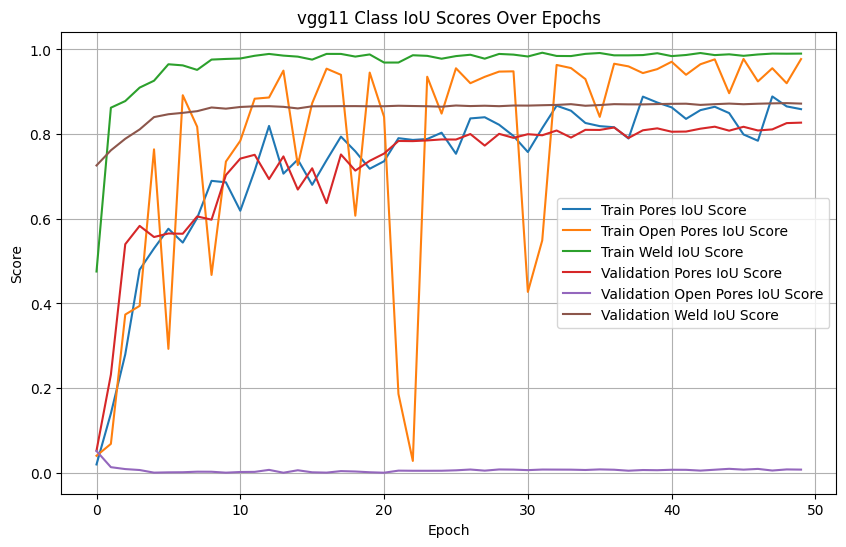

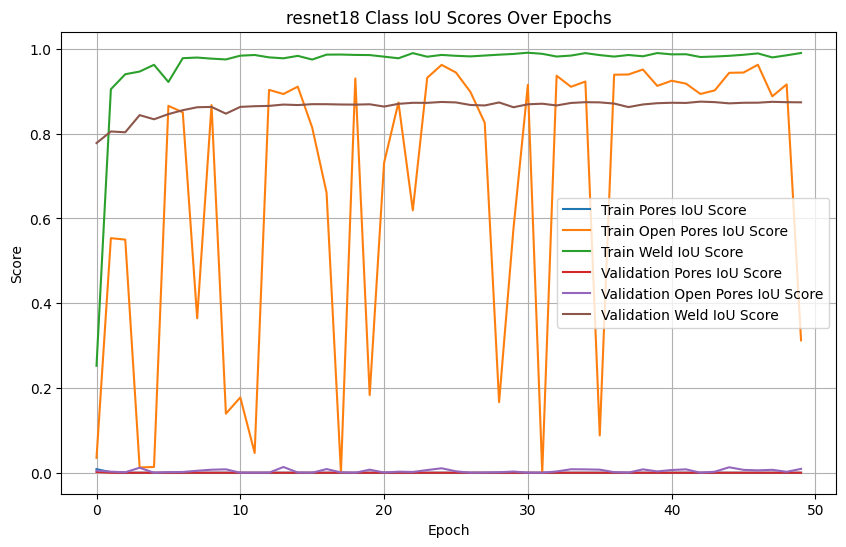

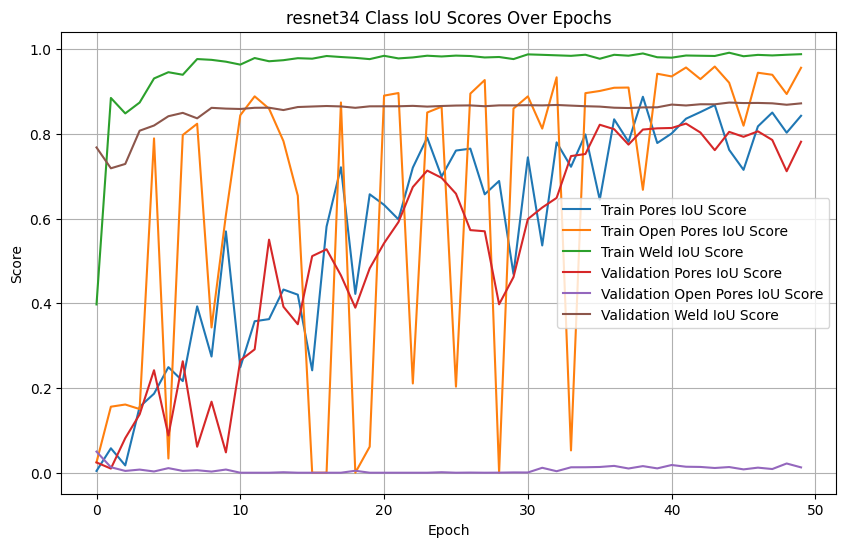

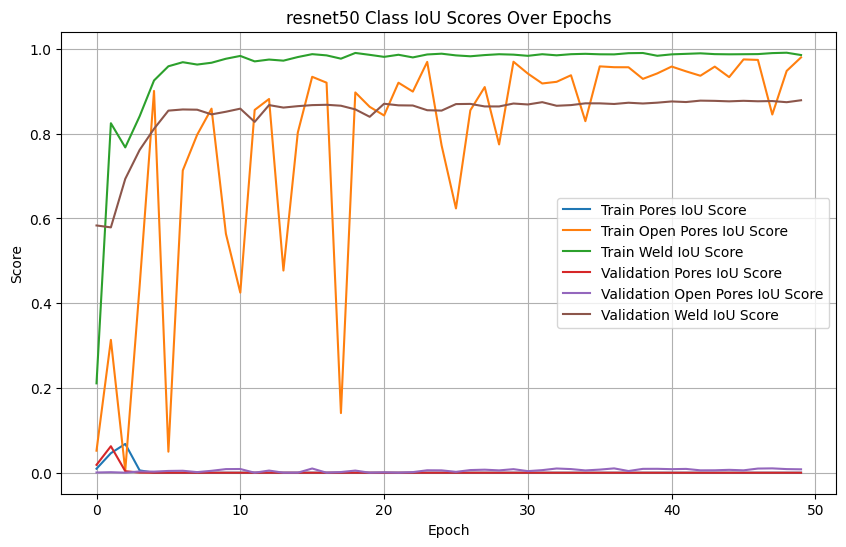

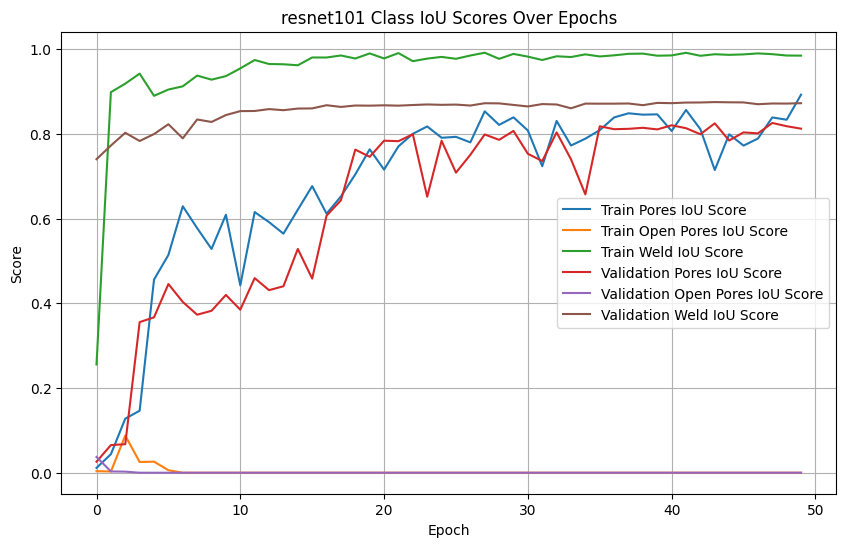

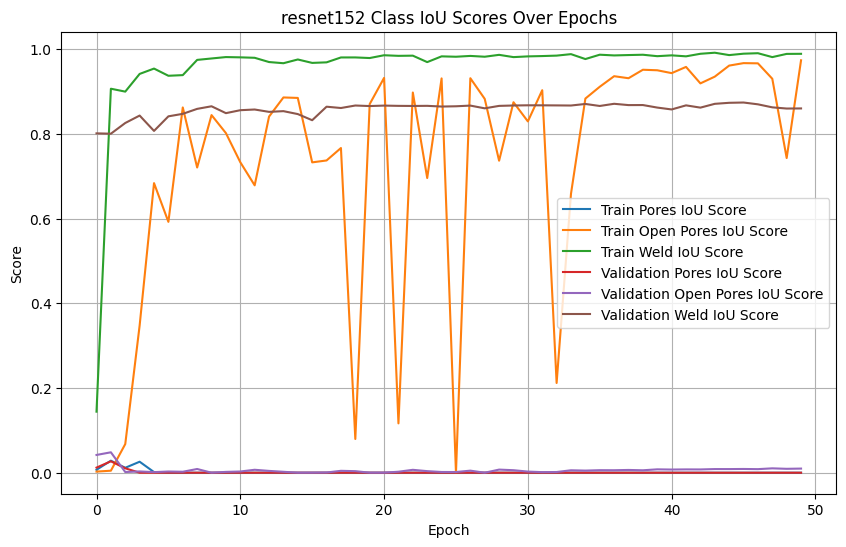

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

def parse_dict(string):
    try:
        return ast.literal_eval(string)
    except ValueError:
        return {}

# List of encoders
encoders = ['vgg11', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']

# Define class names
class_names = ['Pores', 'Open Pores', 'Weld']

# Read CSV files for each encoder and extract scores
for encoder in encoders:
    csv_filename = f"segmentation_results.csv"
    df = pd.read_csv(csv_filename)
    df['Train Class Score'] = df['Train Class Score'].apply(parse_dict)
    df['Val Class Score'] = df['Val Class Score'].apply(parse_dict)

    epochs = []
    encoder_class_iou_scores = {class_name: [] for class_name in class_names}
    val_encoder_class_iou_scores = {class_name: [] for class_name in class_names}

    # Filter rows for the current encoder
    encoder_df = df[df['Encoder'] == encoder]

    for _, row in encoder_df.iterrows():
        epochs.append(row['Epoch'])
        class_iou_scores = row['Train Class Score']
        val_class_iou_scores = row['Val Class Score']
        for class_name in class_names:
            if class_name in class_iou_scores:
                class_iou = class_iou_scores[class_name]['IoU Score']
                encoder_class_iou_scores[class_name].append(class_iou)
            else:
                encoder_class_iou_scores[class_name].append(None)
            if class_name in val_class_iou_scores:
                val_class_iou = val_class_iou_scores[class_name]['IoU Score']
                val_encoder_class_iou_scores[class_name].append(val_class_iou)
            else:
                val_encoder_class_iou_scores[class_name].append(None)

    # Plot graphs for each encoder
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 10})

    for class_name, iou_scores in encoder_class_iou_scores.items():
        plt.plot(epochs, iou_scores, label=f'Train {class_name} IoU Score')

    for class_name, val_iou_scores in val_encoder_class_iou_scores.items():
        plt.plot(epochs, val_iou_scores, label=f'Validation {class_name} IoU Score')

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(f'{encoder} Class IoU Scores Over Epochs')
    plt.legend(loc='right')
    plt.grid(True)
    plt.show()


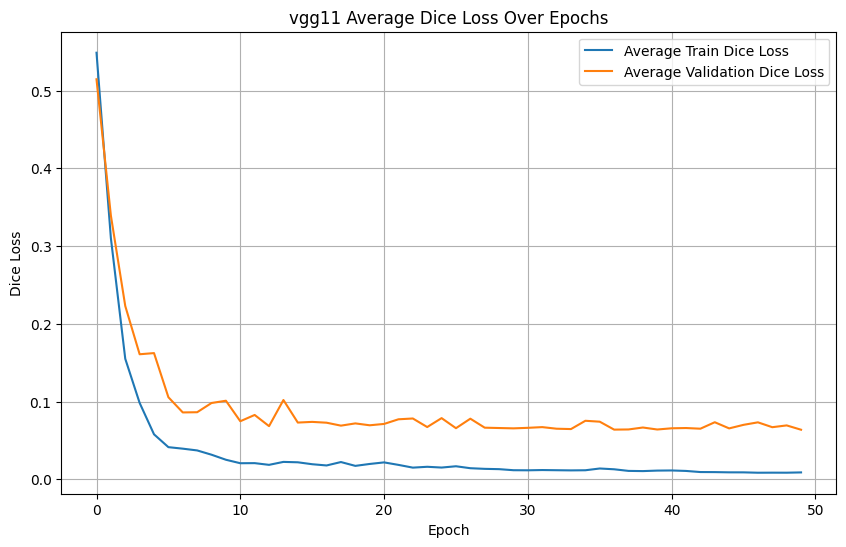

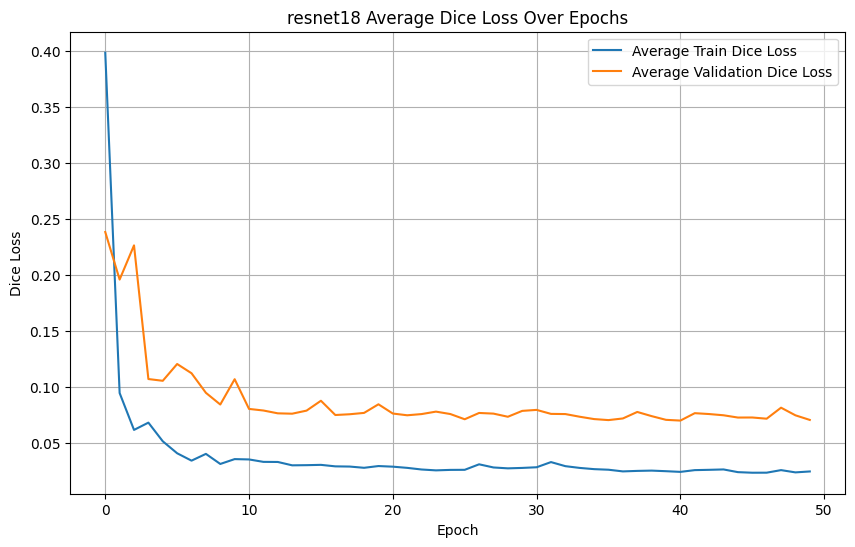

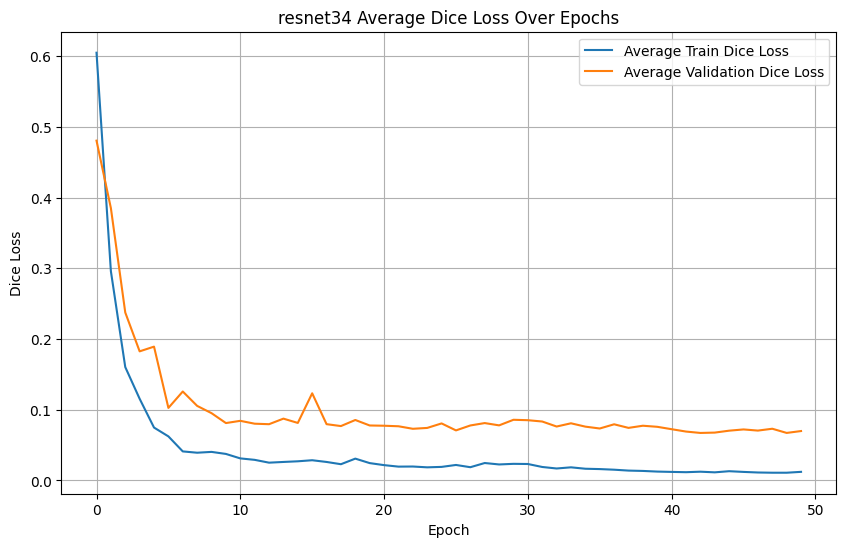

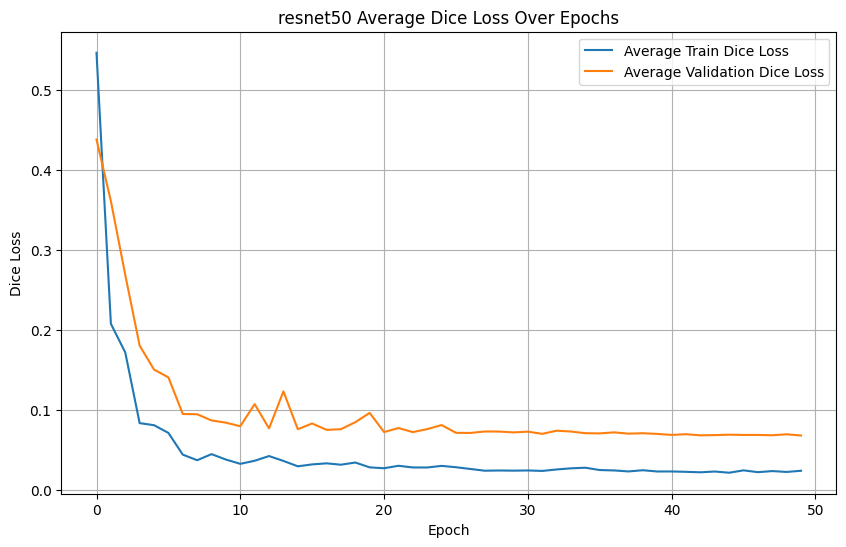

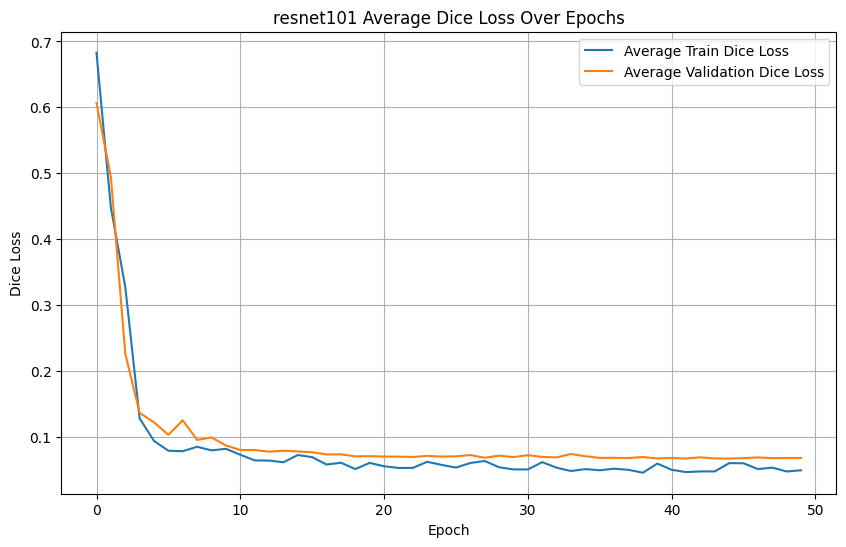

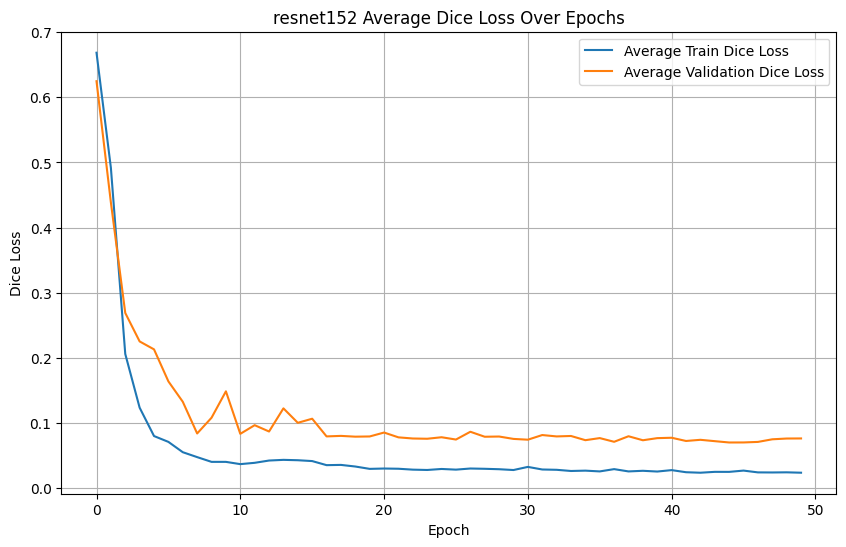

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV files for each encoder
csv_filename = "segmentation_results.csv"
df = pd.read_csv(csv_filename)

# List of encoders
encoders = df['Encoder'].unique()

# Plot graphs for each encoder
for encoder in encoders:
    encoder_df = df[df['Encoder'] == encoder]

    epochs = encoder_df['Epoch']
    avg_train_dice_loss = encoder_df['Avg Train Dice Loss']
    avg_val_dice_loss = encoder_df['Avg Val Dice Loss']

    # Plot average train and validation dice loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_dice_loss, label='Average Train Dice Loss')
    plt.plot(epochs, avg_val_dice_loss, label='Average Validation Dice Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Dice Loss')
    plt.title(f'{encoder} Average Dice Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


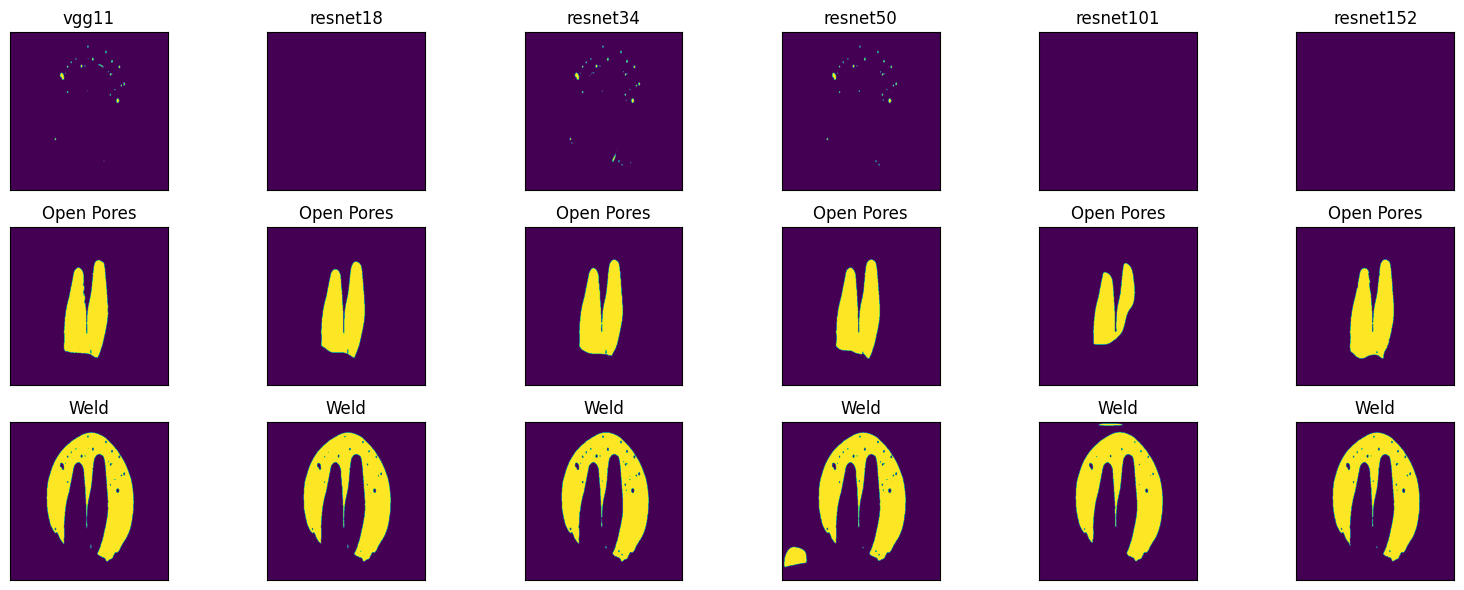

In [18]:
import matplotlib.pyplot as plt
# Define a function to load the best model for a given encoder
def load_best_model(encoder_name, device):
    best_model_path = f"/home/sonawane/backup/best_model_{encoder_name}.pt"
    
    # Define your segmentation model architecture
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights='imagenet',  # Assuming you don't need pre-trained weights here
        classes=num_classes,
        activation='sigmoid',  # Assuming sigmoid activation for binary segmentation
        in_channels=3
    ).to(device)
    
    # Load the state_dict of the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    return model
csv_filename = "segmentation_results.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoders = ['vgg11', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
encoder_weights = 'imagenet'
CLASSES = ['Pores', 'Open Pores', 'Weld']
num_classes = len(CLASSES)
best_model_dir = '/home/sonawane/backup/'# Iterate over each encoder
# Choose a single image index to visualize
image_index = np.random.choice(len(train_dataset))

# Load the image and its corresponding ground truth mask
image_vis = train_dataset[image_index][0].astype('uint8')
image, gt_mask = train_dataset[image_index]

gt_mask = gt_mask.squeeze()

# Initialize subplots
fig, axes = plt.subplots(len(CLASSES), len(encoders), figsize=(16, 6))

# Iterate over each encoder
for i, encoder_name in enumerate(encoders):
    # Load the best model for the current encoder
    best_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_model = load_best_model(encoder_name, best_device)

    # Preprocess the image
    x_tensor = torch.from_numpy(image).to(best_device).unsqueeze(0)

    # Generate prediction using the model
    with torch.no_grad():
        pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()

    # Display the predicted mask for each class
    for j, class_name in enumerate(CLASSES):
        axes[j, i].imshow(pr_mask[j], cmap='viridis')
        axes[j, i].set_title(f"{class_name}")
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])

    # Add the encoder name as the title of the first row
    axes[0, i].set_title(f"{encoder_name}", fontsize=12)

plt.tight_layout()
plt.show()


In [19]:
 # load best saved checkpoint
#best_model = torch.load('./best_model.pth') 

test_kop_dir = '/home/sonawane/backup/2_Keine_offenen_Poren/'
test_kop_list = []
for filename in os.listdir(test_kop_dir):
    if filename.endswith('.tif') and filename.split('.')[0] not in kop_id_list:
        test_kop_list.append(filename.split('.')[0])

################################################################
        
test_op_dir = '/home/sonawane/backup/kikosa_data/1_Offene-Poren/'

test_op_list = []
for filename in os.listdir(test_op_dir):
    if filename.endswith('.tif') and filename.split('.')[0] not in op_ids:
        test_op_list.append(filename.split('.')[0])

print(len(test_op_list))
print(len(test_kop_list))

################################################################
        
test_gop_dir = '/home/sonawane/backup/3_Grenzfall_offene_Pore/'

test_gop_list = []
for filename in os.listdir(test_gop_dir):
    if filename.endswith('.tif') and filename.split('.')[0] not in gop_ids:
        test_gop_list.append(filename.split('.')[0])

print(len(test_gop_list))

################################################################
        

test_gkop_dir = '/home/sonawane/backup/4_Grenzfall_keine_offene_Pore/'

test_gkop_list = []
for filename in os.listdir(test_gkop_dir):
    if filename.endswith('.tif') and filename.split('.')[0] not in gkop_id:
        test_gkop_list.append(filename.split('.')[0])
print(len(test_gkop_list))

17
35
18
7


In [20]:
def load_test_data(test_dir, exclude_ids):
    test_list = []
    for filename in os.listdir(test_dir):
        if filename.endswith('.tif') and filename.split('.')[0] not in exclude_ids:
            test_list.append(filename.split('.')[0])
    return test_list

# Load test data for each directory
test_kop_list = load_test_data(train_kop_dir, kop_id_list)
test_op_list = load_test_data(train_op_dir, op_ids)
test_gop_list = load_test_data(train_gop_dir, gop_ids)
test_gkop_list = load_test_data(train_gkop_dir, gkop_id)

# Print the lengths of the test lists
print(len(test_op_list))
print(len(test_kop_list))
print(len(test_gop_list))
print(len(test_gkop_list))


17
35
18
7


In [21]:
class TestDataset(BaseDataset):
    CLASSES = ['Background', 'Pores', 'Open Pores', 'Weld']

    def __init__(self, test_dir, x_test_list, augmentation=None, classes=None, preprocessing=None):
        self.test_dir = test_dir
        self.x_test_list = x_test_list
        self.class_values = classes  # Use class values directly (e.g., [60, 78, 185, 216)]

        self.pixel_to_label = {
            60: 'Background',
            78: 'Open Pores',
            185: 'Pores',
            216: 'Weld',
        }
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    def __len__(self):
        return len(self.x_test_list)

    def __getitem__(self, idx):
        id_ = self.x_test_list[idx]
        img_path = os.path.join(self.test_dir, id_ + '.tif')
        image_pil = Image.open(img_path).convert("RGB")
        image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

    # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image  = sample['image']
        return image


In [22]:
# create keine_offene_porem test dataset
test_kop_dataset = TestDataset(
    train_kop_dir, 
    kop_id_list, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES
)
# create offene_porem test dataset
test_op_dataset = TestDataset(
    train_op_dir, 
    op_ids, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES
)
#create grenzfall offene porem test dataset
test_gop_dataset = TestDataset(
    train_gop_dir, 
    gop_ids, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES
)
#concat two datasets
test_gkop_dataset = TestDataset(
    train_gkop_dir,
    gkop_id,
    augmentation= get_validation_augmentation(),
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=CLASSES
)
test_dataset = ConcatDataset([test_kop_dataset, test_op_dataset, test_gop_dataset,test_gkop_dataset])



In [25]:
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
test_dataloader = DataLoader(test_dataset)
loss_fn = CustomDiceLoss()
print(len(test_dataloader))
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss_fn,
    metrics=metrics,
    device=DEVICE
)

55


In [26]:
# Define a function to load the best model for a given encoder
def load_best_model(encoder_name, device):
    best_model_path = f"/home/sonawane/backup/best_model_{encoder_name}.pt"
    
    # Define your segmentation model architecture
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights='imagenet',  # Assuming you don't need pre-trained weights here
        classes=num_classes,
        activation='sigmoid',  # Assuming sigmoid activation for binary segmentation
        in_channels=3
    ).to(device)
    
    # Load the state_dict of the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    return model
csv_filename = "segmentation_results.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoders = ['vgg11', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
encoder_weights = 'imagenet'
CLASSES = ['Pores', 'Open Pores', 'Weld']
num_classes = len(CLASSES)
best_model_dir = '/home/sonawane/backup/'# Iterate over each encoder

In [27]:
for encoder_name in encoders:
    # Load the best model for the current encoder
    best_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_model = load_best_model(encoder_name, best_device)
    all_predictions = []
    all_classes = []

    with torch.no_grad():
        for images in test_dataloader:  # Assuming 'images' is a batch from your dataloader
        # Move data to the device (e.g., GPU)
            images = images.to(DEVICE)

        # Make predictions
            predictions = best_model(images)

        # Here, `predictions` will have the shape [batch_size, num_classes, height, width]
        # where `num_classes` is the number of output channels/classes

        # Applying softmax to convert logits to probabilities across the channel dimension
            probabilities = torch.softmax(predictions, dim=1)
        
        # If you want class predictions per pixel
            predicted_classes = torch.argmax(probabilities, dim=1)
            all_classes.append(predicted_classes.cpu().numpy())

        # Store probabilities or any other processed results
            all_predictions.append(probabilities.cpu().numpy())

# Concatenate all data in the list to form a single numpy array
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_classes = np.concatenate(all_classes, axis=0)

# Print the shape of predictions to confirm size
print("Shape of predictions:", all_predictions.shape)
print("Shape of class maps:", all_classes.shape)

Shape of predictions: (55, 3, 512, 512)
Shape of class maps: (55, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


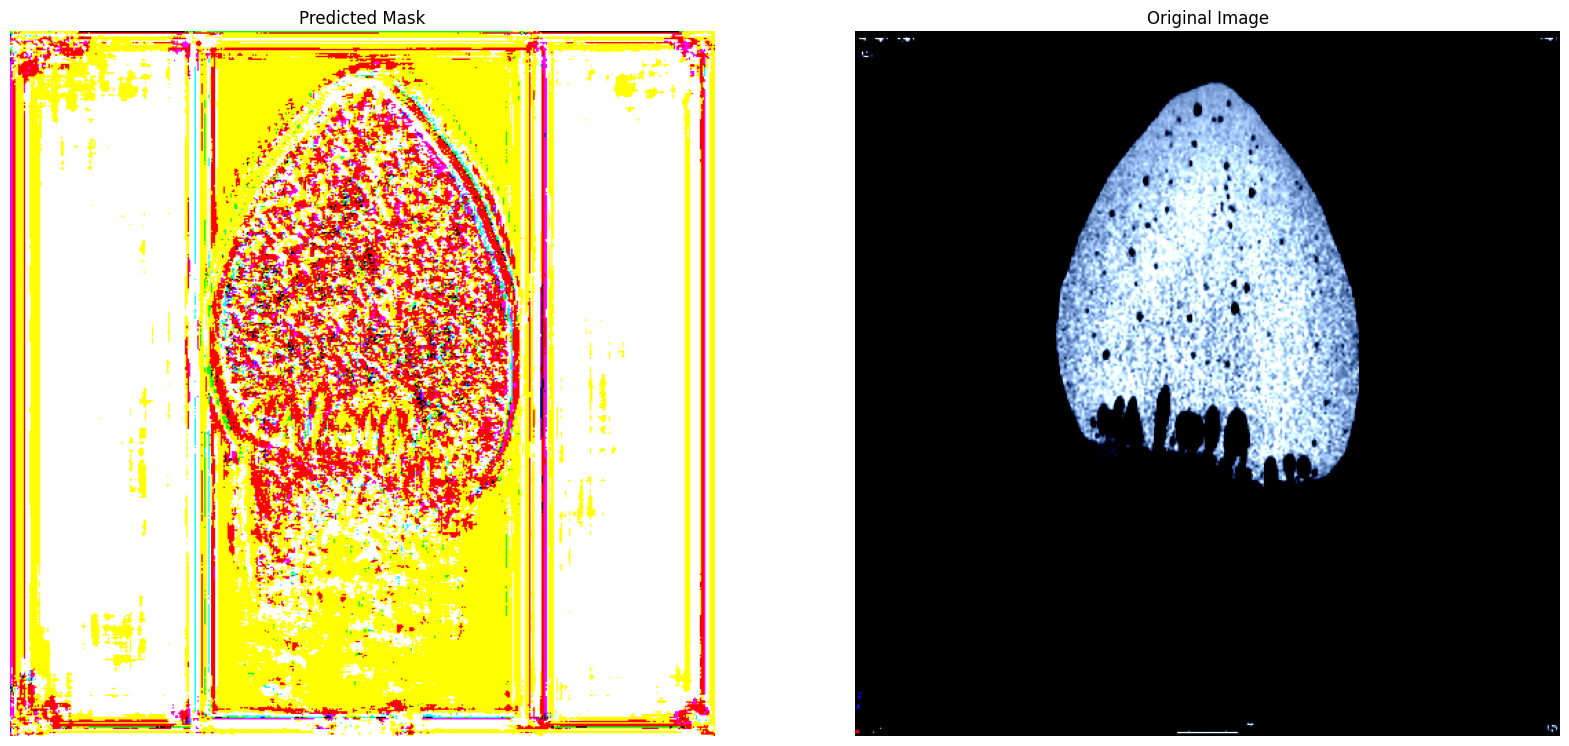

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


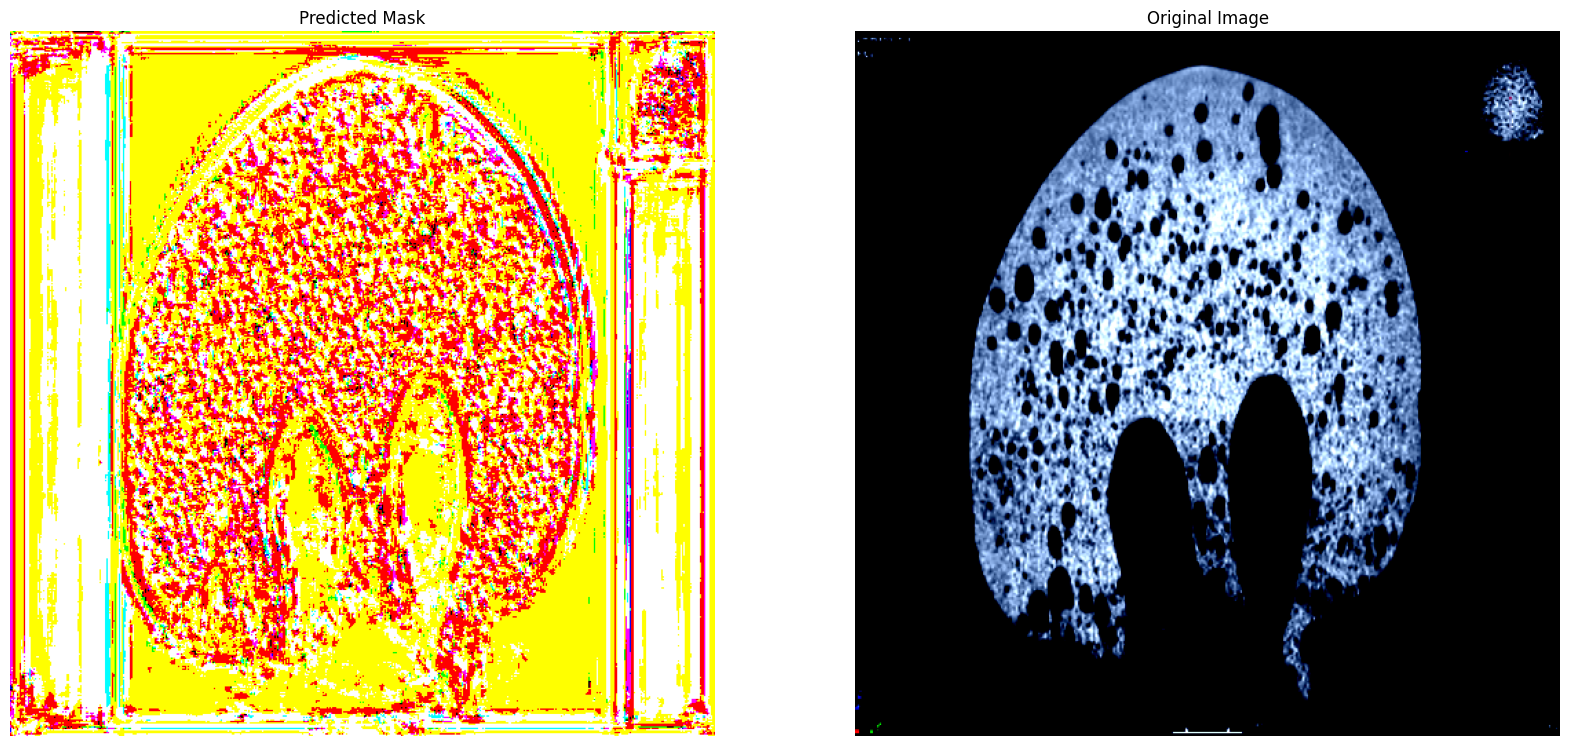

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


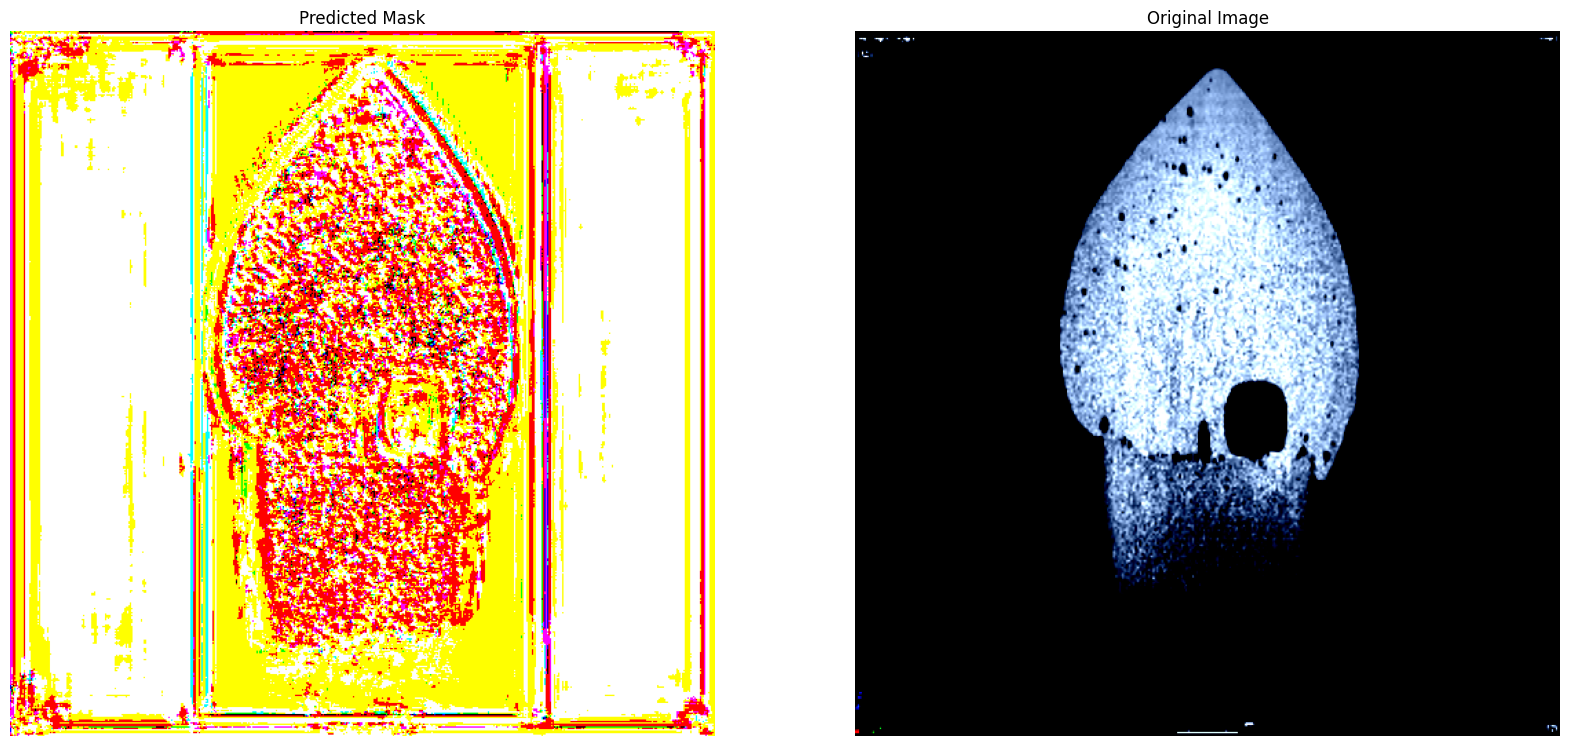

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


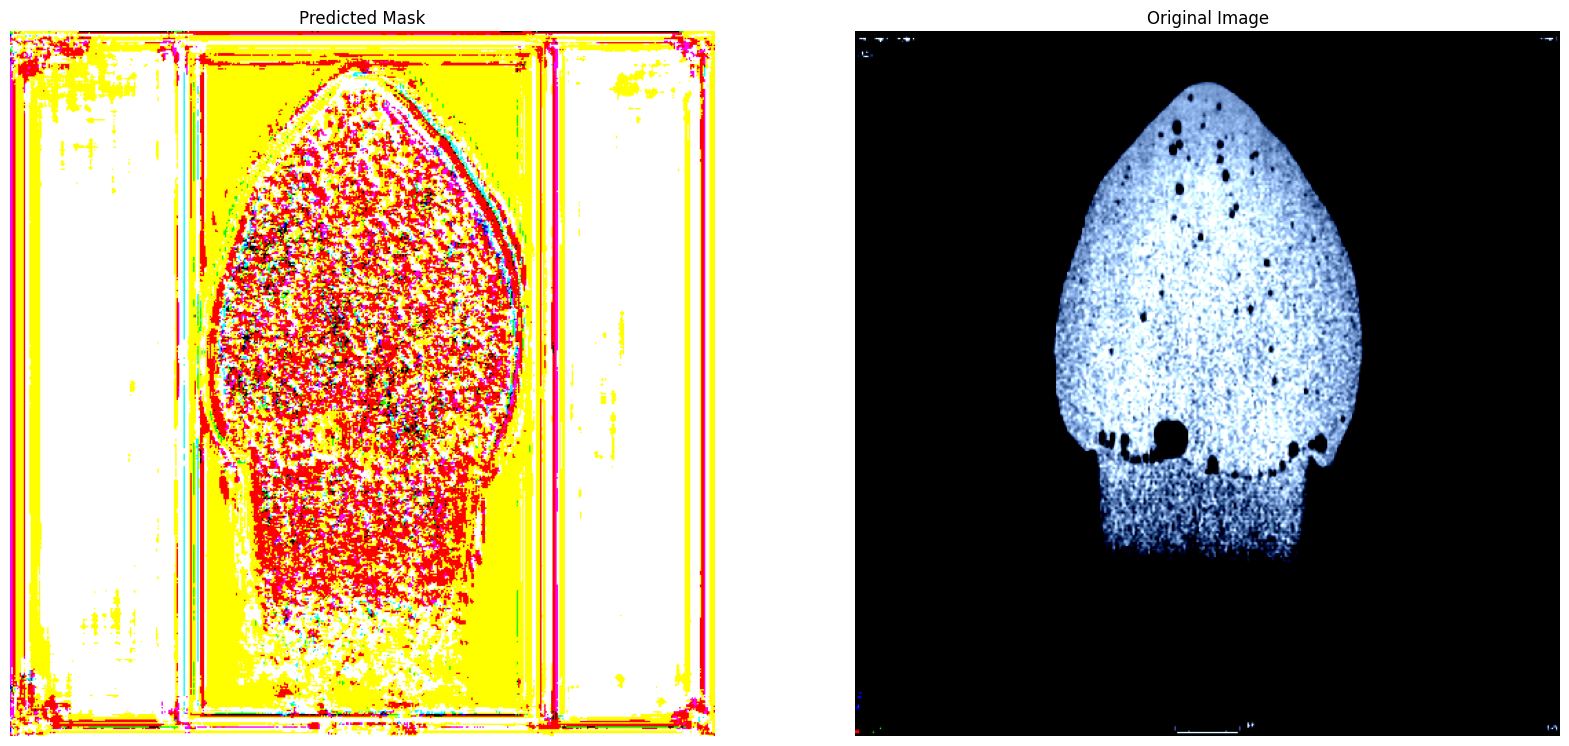

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


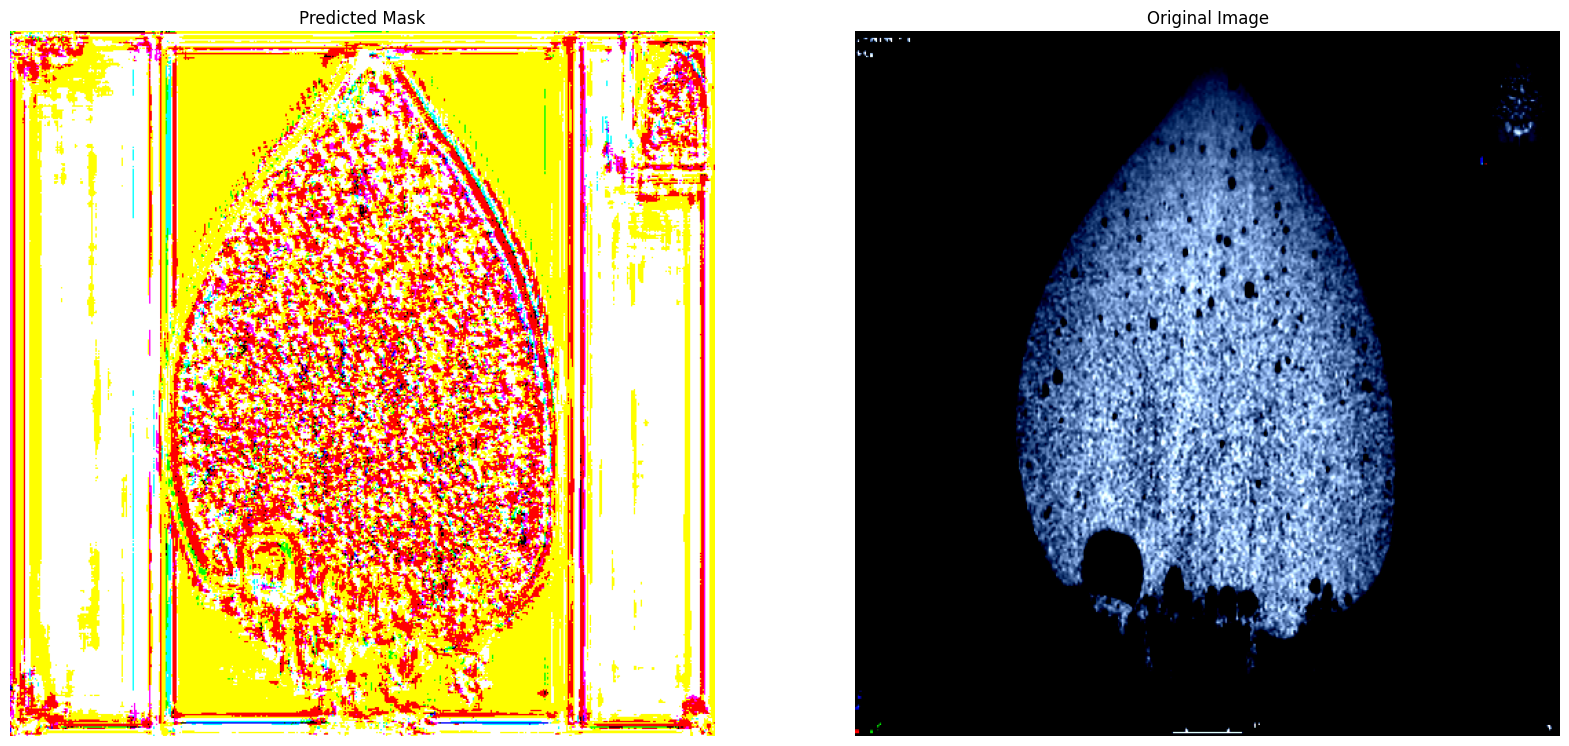

In [28]:
def visualize_channels(predictions, original_image):
    # Scale values to the 0-255 range
    composite_images = (predictions * 255).astype('uint8')

    # Plot the composite image
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Create subplot with two columns

    # Plot the predicted mask
    axes[0].imshow(composite_images.transpose(1, 2, 0))
    axes[0].set_title('Predicted Mask')
    axes[0].axis('off')

    # Plot the original image
    axes[1].imshow(original_image)
    axes[1].set_title('Original Image')
    axes[1].axis('off')

    plt.show()

for i in range(5):
    # Choose a random sample from the test dataset
    n = np.random.choice(len(test_dataset))

    # Get the image and its ground truth mask
    image = test_dataset[n]
    original_image = image.transpose(1, 2, 0)  # Convert image to numpy format for visualization
    gt_mask = gt_mask.squeeze()

    # Convert the image to tensor and move it to the device
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Make predictions
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    # Visualize predicted mask and original image side by side
    visualize_channels(pr_mask, original_image)


55


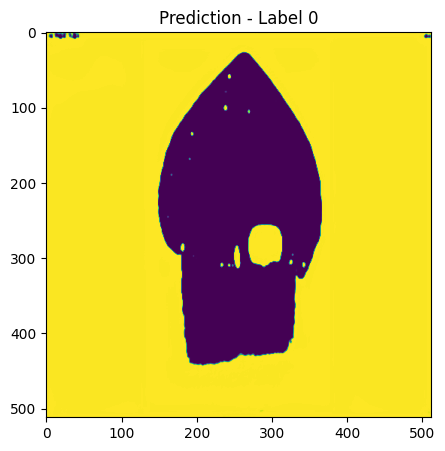

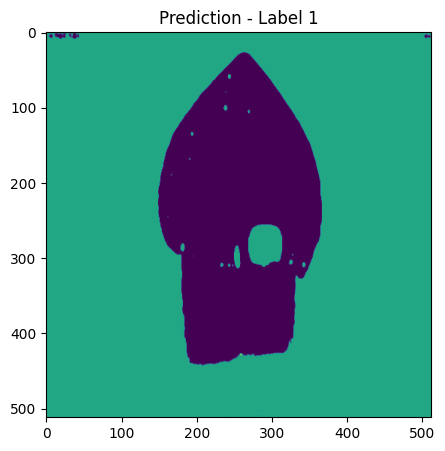

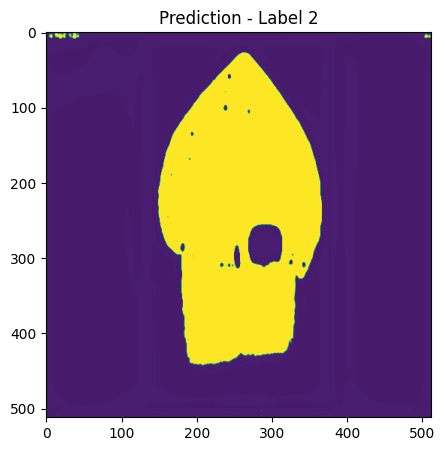

In [32]:
all_predictions_np = np.array(all_predictions)  # Convert to NumPy array
print(len(all_predictions))
# Choose the index of the prediction you want to visualize
selected_prediction_index = 50

# Iterate over the channels and visualize each label
for i in range(all_predictions_np.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.imshow(all_predictions_np[selected_prediction_index, i], cmap='viridis')  # Choose a colormap based on your requirements
    plt.title(f"Prediction - Label {i}")
    plt.show()

In [ ]:
#crop the regional image or prediction
#write all metrics in csv file tocompare with different models
#write codes in classes
#send images to tim
#optuna skip combinations
#refactoring

In [ ]:
#bar plot diagram for iou